## Stresstest av Fintech Enigmas Portefølje per 31.12.2024

Bruker Monte Carlo simulering ved vanlig og 100% økt volatilitet. Modellering av aksjepriser skjer ved bruk av Merton Jump-Diffusion Model, og modellering av oljeprisen brukes  Geometric Mean-Reverting model.


Black-Karasinski Model for Geometric Mean-Revering for modellering av råvarepriser (brent olje):

$ dS_t = \kappa (\mu - ln(S_t) ) S_tdt + \sigma S_t dW_t $

Kou Jump-Diffusion Modell for modellering av akjsepriser:

$ dS_t = \mu S_t dt +\sigma S_t dW_t + S_t (e^J-1)dq_t $

$ J \leftarrow f_J(i) = p \eta_1 e^{\eta_1 i } \textbf{1}_{i>0} + (1-p) \eta_2 e^{eta_2 i } \textbf{1}_{i<0} $

In [308]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy import stats
import yfinance as yf

np.random.seed()

In [252]:
T = 122 # Børsdager jan-juni
dt = 1
N = 1000 # Antall simuleringer

In [253]:
nor_tickers = [ticker + '.OL' for ticker in 'MOWI,KOG,DOFG,BNOR,SCHB,ODL,STB,SEA1'.split(',')]
sv_tickers = ['BETS-B.ST']
eu_tickers = ['GLDA.DE']
fnd_tickers = ['0P0001RFXP.IR']
tickers_yf = nor_tickers + sv_tickers + eu_tickers
tickers = [ticker.split(".")[0] for ticker in tickers_yf]

In [254]:
portfolio = {
    'MOWI': 0.0667,
    'KOG': 0.0299,
    'DOFG': 0.3077,
    'BNOR': 0.1176,
    'SCHB': 0.2181,
    'ODL': 0.0362,
    'STB': 0.0052,
    'SEA1': 0.1069,
    'BETS-B': 0.0971,
    'GLDA': 0.0147
}

In [255]:
df = pd.DataFrame()

for (i, ticker) in enumerate(tickers_yf):
    data = yf.download(ticker, start='2024-01-01', end='2024-12-31', period='1d')
    data = pd.DataFrame(data)
    data.reset_index(inplace=True)
    if i == 0:
        df['Date'] = data['Date']
    df[ticker.split(".")[0]] = data['Close']  

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [256]:
import requests

# URL for the GET request
url = "https://api.e24.no/bors/chart/SEA1.OSE?period=1years&type=stock&withVolume=true"
prices = []

# Perform the GET request
response = requests.get(url)

# Check for successful response
if response.status_code == 200:
    # Parse JSON response
    data = response.json()

    # Convert to DataFrame
    prices = [x[1] for x in data['data'][:-12]]
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


In [257]:
prev_prices = [26.65, 26.85, 26.4, 26.25, 25.8, 25.5, 25.2, 25, 26.15, 25.3, 25, 24.95, 24.65, 25.0]

prices = prev_prices + prices

df['SEA1'] = prices

df

,Date,MOWI,KOG,DOFG,BNOR,SCHB,ODL,STB,SEA1,BETS-B,GLDA
0,2024-01-02,183.350006,471.000000,57.630001,516.0,271.200012,39.650002,91.320000,26.65,108.599998,74.919998
1,2024-01-03,185.600006,470.799988,57.599998,518.0,271.200012,39.150002,91.000000,26.85,107.099998,74.055000
2,2024-01-04,188.800003,482.799988,57.200001,521.0,273.000000,39.099998,91.419998,26.40,108.300003,74.160004
3,2024-01-05,188.699997,483.200012,57.500000,524.0,269.799988,39.299999,91.279999,26.25,107.099998,74.334999
4,2024-01-08,188.399994,481.799988,55.799999,505.0,275.000000,37.950001,91.480003,25.80,109.300003,73.605003
...,...,...,...,...,...,...,...,...,...,...,...
245,2024-12-19,196.000000,1293.000000,81.099998,617.0,333.399994,50.299999,121.099998,24.10,140.779999,100.650002
246,2024-12-20,195.449997,1269.000000,82.400002,616.0,328.000000,49.599998,120.000000,24.15,140.679993,100.199997
247,2024-12-23,194.449997,1291.000000,84.000000,621.0,329.200012,50.099998,120.099998,24.35,141.740005,99.760002
248,2024-12-27,195.699997,1294.000000,84.000000,644.0,333.000000,50.799999,121.800003,24.35,138.860001,99.980003


### Estimering av parametre for aksjepriser til Kou Jump-Diffusion Modellen

In [373]:
params = {}

for ticker in tickers:
    S_t = np.array(df[ticker])
    log_rt = np.array([np.log(S_t[i]/S_t[i-1]) for i in range(1, len(S_t))])
    sd = np.std(log_rt)
    trsht = 3*sd # 

    jumps = log_rt[np.abs(log_rt) > trsht]
    diff = log_rt[np.abs(log_rt) <= trsht]

    mu = np.mean(diff)
    sigma = np.std(diff)

    l_jump = len(jumps) / len(log_rt)

    u_jumps = jumps[jumps > 0]
    d_jumps = jumps[jumps < 0]
    p = len(u_jumps) / len(jumps)

    eta_1 = 1 / np.mean(u_jumps) if len(u_jumps) > 0 else np.inf
    eta_2 = 1 / np.mean(np.abs(d_jumps)) if len(d_jumps) > 0 else np.inf

    params[f'{ticker}:mu'] = mu
    params[f'{ticker}:sigma'] = sigma
    params[f'{ticker}:l_jump'] = l_jump
    params[f'{ticker}:p'] = p
    params[f'{ticker}:eta_1'] = eta_1*100
    params[f'{ticker}:eta_2'] = eta_2*100

params = pd.DataFrame([params])
params

,MOWI:mu,MOWI:sigma,MOWI:l_jump,MOWI:p,MOWI:eta_1,MOWI:eta_2,KOG:mu,KOG:sigma,KOG:l_jump,KOG:p,...,BETS-B:l_jump,BETS-B:p,BETS-B:eta_1,BETS-B:eta_2,GLDA:mu,GLDA:sigma,GLDA:l_jump,GLDA:p,GLDA:eta_1,GLDA:eta_2
0,0.00012,0.010963,0.012048,0.666667,2658.637058,2253.77307,0.00357,0.01677,0.012048,0.666667,...,0.012048,0.666667,958.236414,825.077014,0.001254,0.008159,0.012048,0.333333,3205.740087,3376.606673


In [291]:
corr_mtx = df[tickers]
corr_mtx = corr_mtx.corr()
corr_mtx

,MOWI,KOG,DOFG,BNOR,SCHB,ODL,STB,SEA1,BETS-B,GLDA
MOWI,1.000000,0.023560,-0.426533,0.448805,0.496773,-0.405649,0.063972,0.011251,-0.033006,0.082242
KOG,0.023560,1.000000,0.734275,0.127318,0.556540,0.652623,0.908157,-0.178362,0.876936,0.930466
DOFG,-0.426533,0.734275,1.000000,-0.084462,0.124189,0.921142,0.645245,0.193811,0.592779,0.626442
BNOR,0.448805,0.127318,-0.084462,1.000000,0.475574,0.097313,0.076470,0.309632,0.093994,0.229190
SCHB,0.496773,0.556540,0.124189,0.475574,1.000000,0.152927,0.602633,-0.041224,0.583664,0.674351
ODL,-0.405649,0.652623,0.921142,0.097313,0.152927,1.000000,0.587096,0.319312,0.485463,0.596743
STB,0.063972,0.908157,0.645245,0.076470,0.602633,0.587096,1.000000,-0.252210,0.874433,0.922592
SEA1,0.011251,-0.178362,0.193811,0.309632,-0.041224,0.319312,-0.252210,1.000000,-0.352771,-0.136911
BETS-B,-0.033006,0.876936,0.592779,0.093994,0.583664,0.485463,0.874433,-0.352771,1.000000,0.842293
GLDA,0.082242,0.930466,0.626442,0.229190,0.674351,0.596743,0.922592,-0.136911,0.842293,1.000000


### Estimering av parametre av brent oilje pris til Black-Karasinski Modellen

Skriver om til diskret verskjon 

$ X_t = ln(S_t) $

$ \Delta X_t = \kappa (\mu - X_t) \Delta t + \sigma \sqrt{\Delta t} W_t $

In [292]:
crude = yf.download('BZ=F', '2024-01-01', '2024-12-31', period='1d')
crude = pd.DataFrame(crude)
crude.reset_index(inplace=True)
crude = crude[['Date', 'Close']]
crude.head(10)

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2024-01-02,75.889999
1,2024-01-03,78.250000
2,2024-01-04,77.589996
3,2024-01-05,78.760002
4,2024-01-08,76.120003
5,2024-01-09,77.589996
6,2024-01-10,76.800003
7,2024-01-11,77.410004
8,2024-01-12,78.290001
9,2024-01-16,78.290001


In [293]:
X = np.log(crude['Close'])

dX = np.diff(X)  # ΔX_t
X_lag = X[:-1]   # X_t

# Step 2: Perform OLS regression to estimate A and B
X_lag = sm.add_constant(X_lag)  # Add intercept term
model = sm.OLS(dX, X_lag).fit()
A, B = model.params

kappa = -B / dt/T
mu = A / B / 100

residuals = model.resid
sigma = np.std(residuals) / np.sqrt(dt)

crude_params = {'mu': mu, 'kappa': kappa, 'sigma': sigma}
crude_params

{'mu': -0.04375353542929924,
 'kappa': 0.00024290314497686714,
 'sigma': 0.016595208326817764}

In [294]:
df_w_crude = df.copy()
df_w_crude = pd.merge(df_w_crude, how='left', on='Date', right=crude)

df_w_crude['Crude'] = df_w_crude['Close']
del df_w_crude['Close']

df_w_crude_corr = df_w_crude.corr()

crude_corr = {}

for ticker in tickers:
    crude_corr[ticker] = df_w_crude_corr[ticker]['Crude']

crude_corr = pd.DataFrame([crude_corr])
crude_corr

,MOWI,KOG,DOFG,BNOR,SCHB,ODL,STB,SEA1,BETS-B,GLDA
0,-0.14229,-0.591908,-0.1564,0.291682,-0.328524,0.022726,-0.654707,0.685751,-0.661852,-0.557867


## Monte Carlo Simulering av Portefølje gitt standard parametre

In [381]:
paths = {ticker: np.zeros((N, T)) for ticker in tickers}

for ticker in tickers:
    paths[ticker][:, 0] = df.iloc[-1][ticker]

for t in range(1, T):
    Z = np.random.normal(size=(N, len(tickers)))
    L = np.linalg.cholesky(corr_mtx)
    Z = np.dot(L, Z.T).T

    for i, ticker in enumerate(tickers):
        dW = np.sqrt(dt) * Z[:, i]

        # Vectorized jump sizes
        upward_jumps = np.random.poisson(params[f'{ticker}:l_jump'] * params[f'{ticker}:p'] * dt, N)
        downward_jumps = np.random.poisson(params[f'{ticker}:l_jump'] * (1 - params[f'{ticker}:p']) * dt, N)
        jump_sizes = (
            upward_jumps * np.random.exponential(1/params[f'{ticker}:eta_1'], N)
            - downward_jumps * np.random.exponential(1/params[f'{ticker}:eta_2'], N)
        )

        W = 1 + float(params[f'{ticker}:mu']) * dt + float(params[f'{ticker}:sigma']) * dW + jump_sizes 

        # Update stock price
        paths[ticker][:, t] = np.array(paths[ticker][:, t-1]) * W

C:\Users\naths\AppData\Local\Temp\ipykernel_27028\2224706948.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = 1 + float(params[f'{ticker}:mu']) * dt + float(params[f'{ticker}:sigma']) * dW + jump_sizes


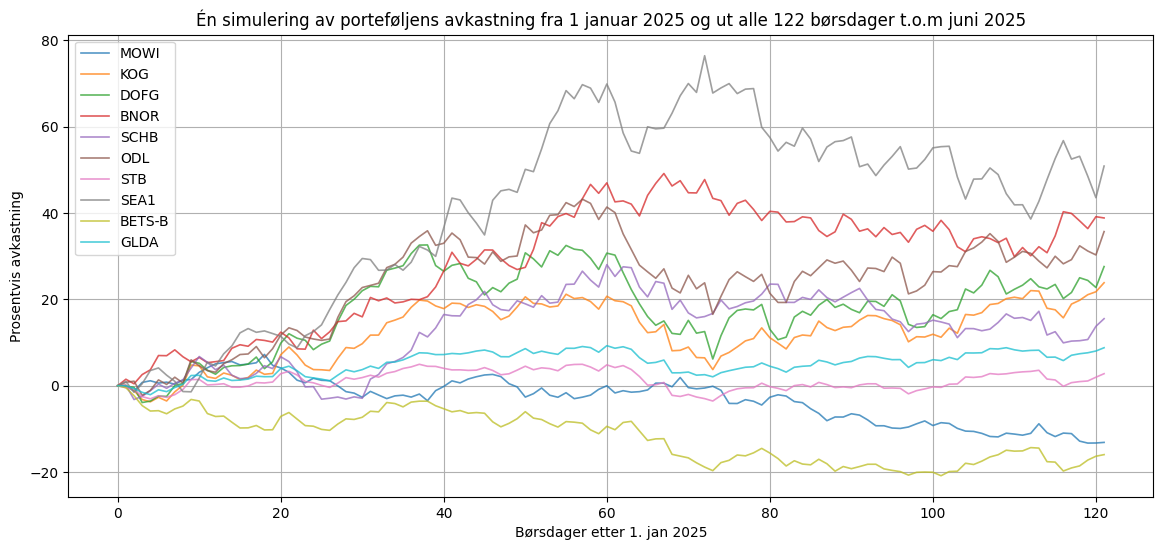

In [382]:
time = range(T)
i = 100
plt.figure(figsize=(14, 6))
for ticker in tickers:
    plt.plot(time, 100*(paths[ticker][i]/paths[ticker][i][0] - 1), label=ticker, lw=1.2, alpha=0.75)

plt.legend()
plt.title("Én simulering av porteføljens avkastning fra 1 januar 2025 og ut alle 122 børsdager t.o.m juni 2025")
plt.grid()
plt.xlabel("Børsdager etter 1. jan 2025")
plt.ylabel("Prosentvis avkastning")
plt.show()

#### VaR analyse av simuleringen

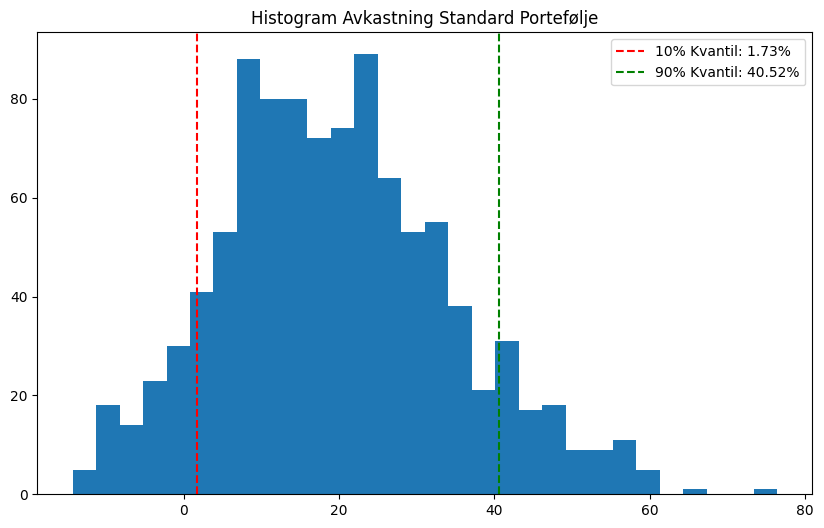

UPI: 1.9698563453117333


In [383]:
avkastninger = {ticker: np.zeros(N) for ticker in tickers}

for ticker in tickers:
    r = 100*(paths[ticker][:, T-1] / paths[ticker][:, 0] - 1)
    avkastninger[ticker] = r

avkastninger_portfolio = []

for i in range(N):
    avkast = 0
    for ticker in tickers:
        avkast += avkastninger[ticker][i] * portfolio[ticker]

    avkastninger_portfolio.append(avkast)

mu_r = np.mean(avkastninger_portfolio)
sd_r = np.sqrt(np.var(avkastninger_portfolio))
_10q = np.sort(avkastninger_portfolio)[int((N-1)*0.1 + 1)]
_90q = np.sort(avkastninger_portfolio)[int((N-1)*0.9 + 1)]

plt.figure(figsize=(10, 6))
plt.hist(avkastninger_portfolio, 30)
plt.title("Histogram Avkastning Standard Portefølje")
plt.axvline(_10q, color="red", linestyle="--", label=f"10% Kvantil: {round(_10q, 2)}%")
plt.axvline(_90q, color="green", linestyle="--", label=f"90% Kvantil: {round(_90q, 2)}%")
plt.legend()

plt.show()
print(f'UPI: {( _90q - abs(_10q))/mu_r}')

## Monte Carlo Simulering av Portefølje gitt økende volatilitet opp til 100% økning 

$ \Delta \sigma \leftarrow N( \sqrt[T]{20}-1 , \frac{\sqrt[T]{20}-1}{4} ) $

In [384]:
paths = {ticker: np.zeros((N, T)) for ticker in tickers}

d_sigma = np.power(2, 1/T) - 1
sigma_sigma = (d_sigma) / 4

for ticker in tickers:
    paths[ticker][:, 0] = df.iloc[-1][ticker]

for t in range(1, T):
    Z = np.random.normal(size=(N, len(tickers))) * np.exp(np.random.normal(d_sigma, sigma_sigma) * t)
    L = np.linalg.cholesky(corr_mtx)
    Z = np.dot(L, Z.T).T

    for i, ticker in enumerate(tickers):
        dW = np.sqrt(dt) * Z[:, i]

        # Vectorized jump sizes
        upward_jumps = np.random.poisson(params[f'{ticker}:l_jump'] * params[f'{ticker}:p'] * dt, N)
        downward_jumps = np.random.poisson(params[f'{ticker}:l_jump'] * (1 - params[f'{ticker}:p']) * dt, N)
        jump_sizes = (
            upward_jumps * np.random.exponential(1/params[f'{ticker}:eta_1'], N)
            - downward_jumps * np.random.exponential(1/params[f'{ticker}:eta_2'], N)
        )

        W = 1 + float(params[f'{ticker}:mu']) * dt + float(params[f'{ticker}:sigma']) * dW + jump_sizes 

        # Update stock price
        paths[ticker][:, t] = np.array(paths[ticker][:, t-1]) * W

C:\Users\naths\AppData\Local\Temp\ipykernel_27028\1636712651.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = 1 + float(params[f'{ticker}:mu']) * dt + float(params[f'{ticker}:sigma']) * dW + jump_sizes


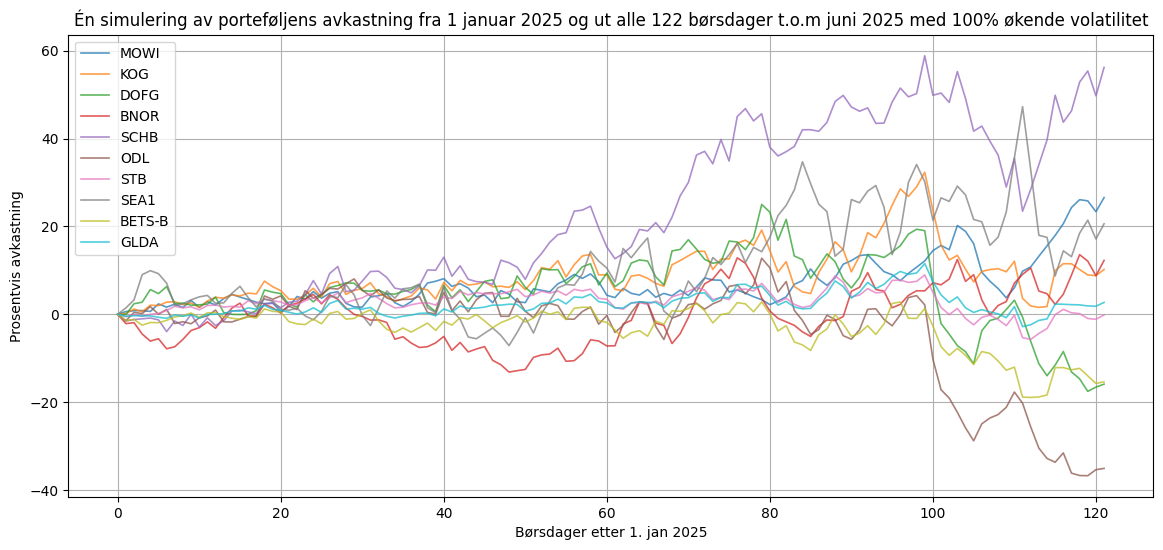

In [385]:
time = range(T)
i = 179
plt.figure(figsize=(14, 6))
for ticker in tickers:
    plt.plot(time, 100*(paths[ticker][i]/paths[ticker][i][0] - 1), label=ticker, lw=1.2, alpha=0.75)

plt.legend()
plt.title(f'Én simulering av porteføljens avkastning fra 1 januar 2025 og ut alle 122 børsdager t.o.m juni 2025 med 100% økende volatilitet')
plt.grid()
plt.xlabel("Børsdager etter 1. jan 2025")
plt.ylabel("Prosentvis avkastning")
plt.show()

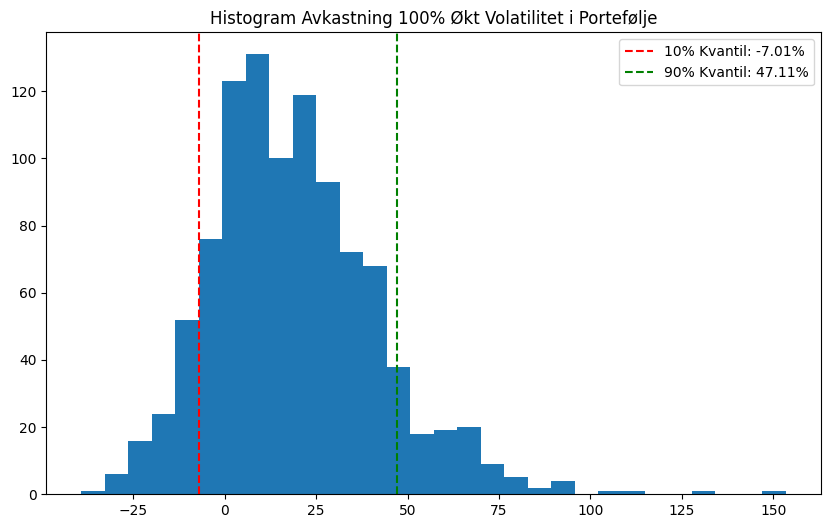

UPI: 2.118302803353058


In [386]:
avkastninger = {ticker: np.zeros(N) for ticker in tickers}

for ticker in tickers:
    r = 100*(paths[ticker][:, T-1] / paths[ticker][:, 0] - 1)
    avkastninger[ticker] = r

avkastninger_portfolio = []

for i in range(N):
    avkast = 0
    for ticker in tickers:
        avkast += avkastninger[ticker][i] * portfolio[ticker]

    avkastninger_portfolio.append(avkast)

mu_r = np.mean(avkastninger_portfolio)
sd_r = np.sqrt(np.var(avkastninger_portfolio))
_10q = np.sort(avkastninger_portfolio)[int((N-1)*0.1 + 1)]
_90q = np.sort(avkastninger_portfolio)[int((N-1)*0.9 + 1)]

plt.figure(figsize=(10, 6))
plt.hist(avkastninger_portfolio, 30)
plt.title("Histogram Avkastning 100% Økt Volatilitet i Portefølje")
plt.axvline(_10q, color="red", linestyle="--", label=f"10% Kvantil: {round(_10q, 2)}%")
plt.axvline(_90q, color="green", linestyle="--", label=f"90% Kvantil: {round(_90q, 2)}%")
plt.legend()

plt.show()
print(f'UPI: {( _90q - abs(_10q))/mu_r}')

## Monte Carlo Simulering av Porteføljen gitt oljeprisens bevegelse

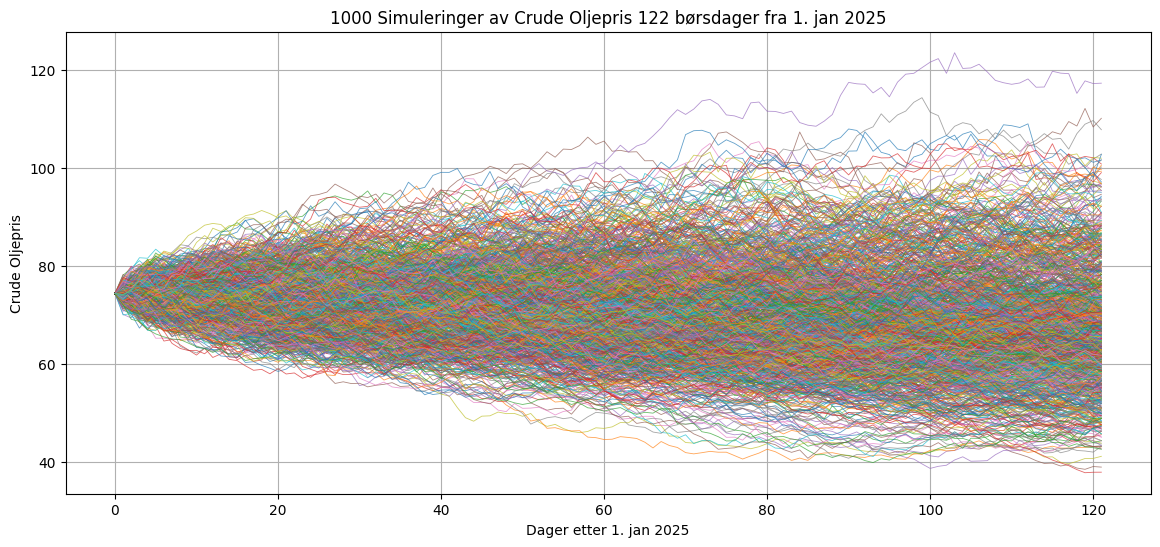

In [387]:
C_t = np.zeros((N,T))
C_t[:, 0] = np.log(crude.iloc[-1]['Close'])

for t in range(1, T):
    Z = np.random.normal(size=N)
    dW = np.sqrt(dt)*Z
    

    dX = float(crude_params['kappa']) * (float(crude_params['mu']) - C_t[:, t-1]) * dt + float(crude_params['sigma']) * dW
    C_t[:, t] = C_t[:, t-1] + dX


plt.figure(figsize=(14, 6))
for n in range(N):
    plt.plot(time, np.exp(C_t[n]), lw=0.6, alpha=0.7)

plt.title("1000 Simuleringer av Crude Oljepris 122 børsdager fra 1. jan 2025")
plt.grid()
plt.xlabel("Dager etter 1. jan 2025")
plt.ylabel("Crude Oljepris")
plt.show()

In [391]:
paths = {ticker: np.zeros((N, T)) for ticker in tickers}

for ticker in tickers:
    paths[ticker][:, 0] = df.iloc[-1][ticker]

for t in range(1, T):
    Z = np.random.normal(size=(N, len(tickers)))
    L = np.linalg.cholesky(corr_mtx)
    Z = np.dot(L, Z.T).T

    for i, ticker in enumerate(tickers):
        dW = np.sqrt(dt) * Z[:, i]

        crude_correlation = float(crude_corr[ticker])
        corr_c = np.array([
            [1, crude_correlation],
            [crude_correlation, 1]
        ])
        L_c = np.linalg.cholesky(corr_c)

        crude_returns = 100 * (C_t[:, t] - C_t[:, t-1]) / C_t[:, t-1] if t > 1 else np.zeros(N)

        # Combine dW and crude returns for transformation
        adjusted_factors = np.vstack([dW, crude_returns]).T
        dW_adjusted = np.dot(adjusted_factors, L_c).T[0]

        # Vectorized jump sizes
        upward_jumps = np.random.poisson(params[f'{ticker}:l_jump'] * params[f'{ticker}:p'] * dt, N)
        downward_jumps = np.random.poisson(params[f'{ticker}:l_jump'] * (1 - params[f'{ticker}:p']) * dt, N)
        jump_sizes = (
            upward_jumps * np.random.exponential(1/params[f'{ticker}:eta_1'], N)
            - downward_jumps * np.random.exponential(1/params[f'{ticker}:eta_2'], N)
        )

        W = 1 + float(params[f'{ticker}:mu']) * dt + float(params[f'{ticker}:sigma']) * dW_adjusted + jump_sizes 

        # Update stock price
        paths[ticker][:, t] = np.array(paths[ticker][:, t-1]) * W

C:\Users\naths\AppData\Local\Temp\ipykernel_27028\3050359671.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  crude_correlation = float(crude_corr[ticker])
C:\Users\naths\AppData\Local\Temp\ipykernel_27028\3050359671.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = 1 + float(params[f'{ticker}:mu']) * dt + float(params[f'{ticker}:sigma']) * dW_adjusted + jump_sizes


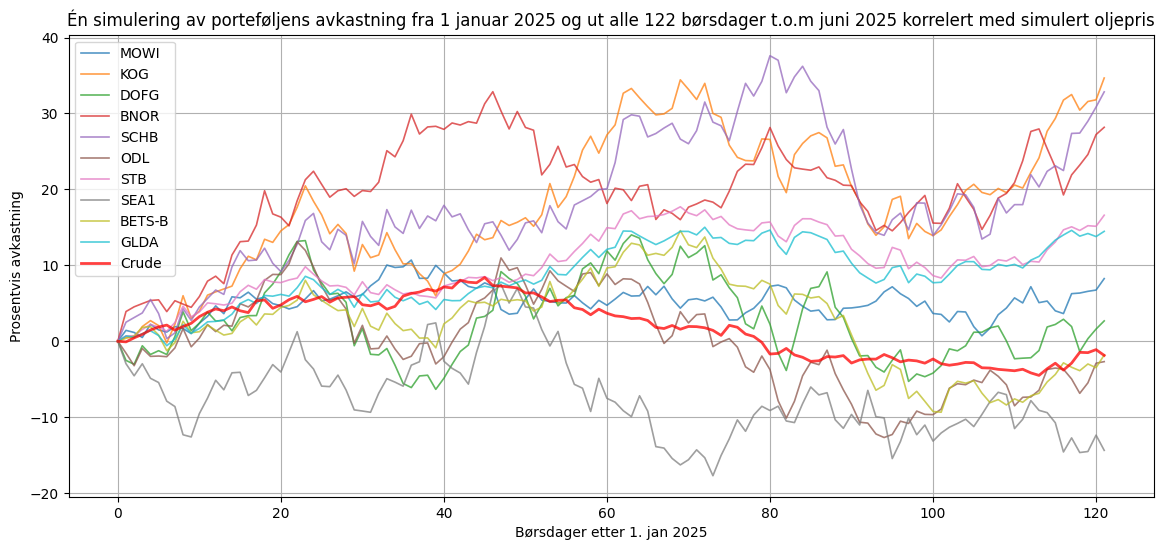

In [392]:
time = range(T)
i = 486
plt.figure(figsize=(14, 6))
for ticker in tickers:
    plt.plot(time, 100*(paths[ticker][i]/paths[ticker][i][0] - 1), label=ticker, lw=1.2, alpha=0.75)

plt.plot(time, 100*(C_t[i] / C_t[0] - 1), label='Crude', lw=2, alpha=0.75, color='red')

plt.legend()
plt.title(f'Én simulering av porteføljens avkastning fra 1 januar 2025 og ut alle 122 børsdager t.o.m juni 2025 korrelert med simulert oljepris')
plt.grid()
plt.xlabel("Børsdager etter 1. jan 2025")
plt.ylabel("Prosentvis avkastning")
plt.show()

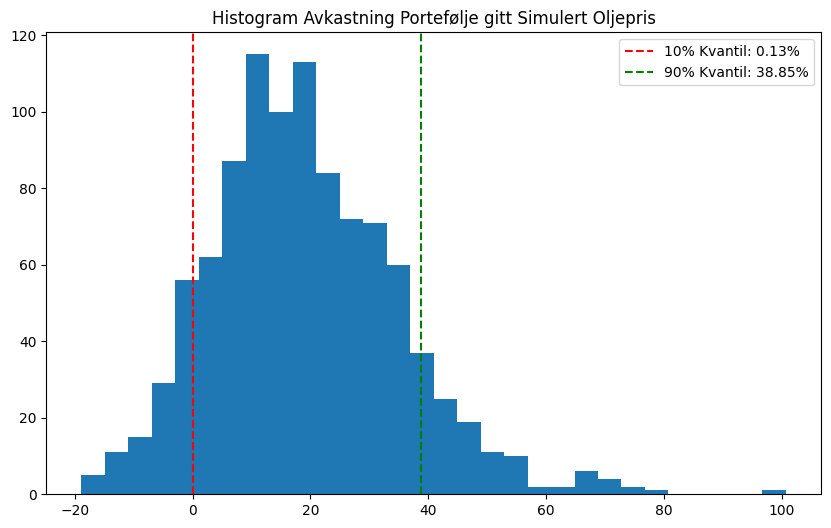

UPI: 2.031774413940771


In [393]:
avkastninger = {ticker: np.zeros(N) for ticker in tickers}

for ticker in tickers:
    r = 100*(paths[ticker][:, T-1] / paths[ticker][:, 0] - 1)
    avkastninger[ticker] = r

avkastninger_portfolio = []

for i in range(N):
    avkast = 0
    for ticker in tickers:
        avkast += avkastninger[ticker][i] * portfolio[ticker]

    avkastninger_portfolio.append(avkast)

mu_r = np.mean(avkastninger_portfolio)
sd_r = np.sqrt(np.var(avkastninger_portfolio))
_10q = np.sort(avkastninger_portfolio)[int((N-1)*0.1 + 1)]
_90q = np.sort(avkastninger_portfolio)[int((N-1)*0.9 + 1)]

plt.figure(figsize=(10, 6))
plt.hist(avkastninger_portfolio, 30)
plt.title("Histogram Avkastning Portefølje gitt Simulert Oljepris")
plt.axvline(_10q, color="red", linestyle="--", label=f"10% Kvantil: {round(_10q, 2)}%")
plt.axvline(_90q, color="green", linestyle="--", label=f"90% Kvantil: {round(_90q, 2)}%")
plt.legend()

plt.show()
print(f'UPI: {( _90q - abs(_10q))/mu_r}')

## Monte Carlo Simulering av Porteføljen gitt oljeprisens bevegelse med økende volatilitet opp til 100%

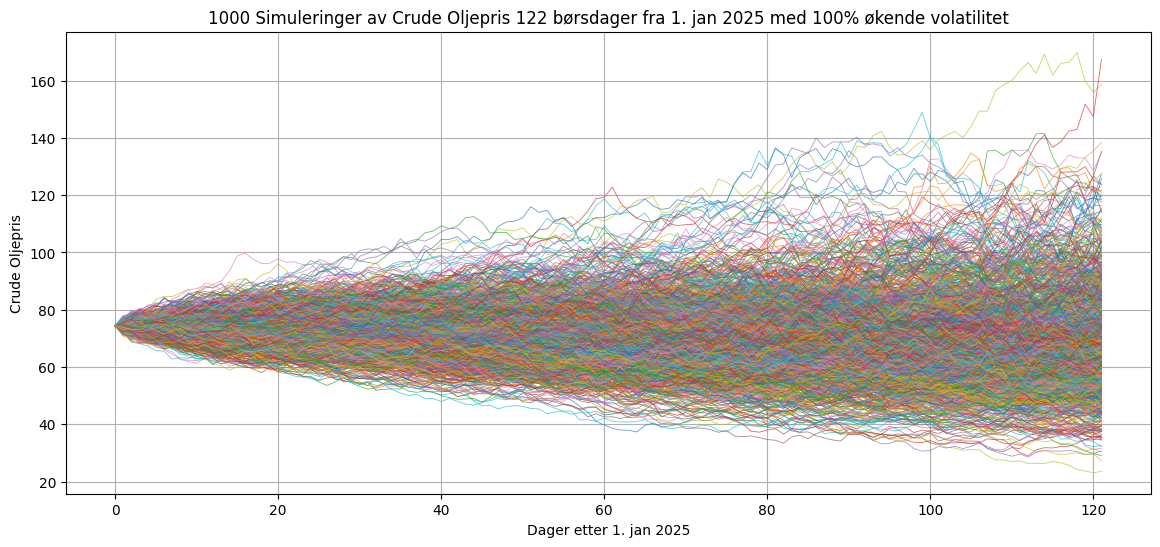

In [394]:
C_t = np.zeros((N,T))
C_t[:, 0] = np.log(crude.iloc[-1]['Close'])
d_sigma = np.power(2, 1/T) - 1
sigma_sigma = (d_sigma) / 4

for t in range(1, T):
    Z = np.random.normal(size=N)
    dW = np.sqrt(dt)*Z
    

    dX = float(crude_params['kappa']) * (float(crude_params['mu']) - C_t[:, t-1]) * dt + np.exp(np.random.normal(d_sigma, sigma_sigma) * t) * float(crude_params['sigma']) * dW
    C_t[:, t] = C_t[:, t-1] + dX


plt.figure(figsize=(14, 6))
for n in range(N):
    plt.plot(time, np.exp(C_t[n]), lw=0.6, alpha=0.7)

plt.title("1000 Simuleringer av Crude Oljepris 122 børsdager fra 1. jan 2025 med 100% økende volatilitet")
plt.grid()
plt.xlabel("Dager etter 1. jan 2025")
plt.ylabel("Crude Oljepris")
plt.show()

In [398]:
paths = {ticker: np.zeros((N, T)) for ticker in tickers}

for ticker in tickers:
    paths[ticker][:, 0] = df.iloc[-1][ticker]

for t in range(1, T):
    Z = np.random.normal(size=(N, len(tickers)))
    L = np.linalg.cholesky(corr_mtx)
    Z = np.dot(L, Z.T).T

    for i, ticker in enumerate(tickers):
        dW = np.sqrt(dt) * Z[:, i]

        crude_correlation = float(crude_corr[ticker])
        corr_c = np.array([
            [1, crude_correlation],
            [crude_correlation, 1]
        ])
        L_c = np.linalg.cholesky(corr_c)

        crude_returns = 100 * (C_t[:, t] - C_t[:, t-1]) / C_t[:, t-1] if t > 1 else np.zeros(N)

        # Combine dW and crude returns for transformation
        adjusted_factors = np.vstack([dW, crude_returns]).T
        dW_adjusted = np.dot(adjusted_factors, L_c).T[0]

        # Vectorized jump sizes
        upward_jumps = np.random.poisson(params[f'{ticker}:l_jump'] * params[f'{ticker}:p'] * dt, N)
        downward_jumps = np.random.poisson(params[f'{ticker}:l_jump'] * (1 - params[f'{ticker}:p']) * dt, N)
        jump_sizes = (
            upward_jumps * np.random.exponential(1/params[f'{ticker}:eta_1'], N)
            - downward_jumps * np.random.exponential(1/params[f'{ticker}:eta_2'], N)
        )

        W = 1 + float(params[f'{ticker}:mu']) * dt + float(params[f'{ticker}:sigma']) * dW_adjusted + jump_sizes 

        # Update stock price
        paths[ticker][:, t] = np.array(paths[ticker][:, t-1]) * W

C:\Users\naths\AppData\Local\Temp\ipykernel_27028\3050359671.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  crude_correlation = float(crude_corr[ticker])
C:\Users\naths\AppData\Local\Temp\ipykernel_27028\3050359671.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  W = 1 + float(params[f'{ticker}:mu']) * dt + float(params[f'{ticker}:sigma']) * dW_adjusted + jump_sizes


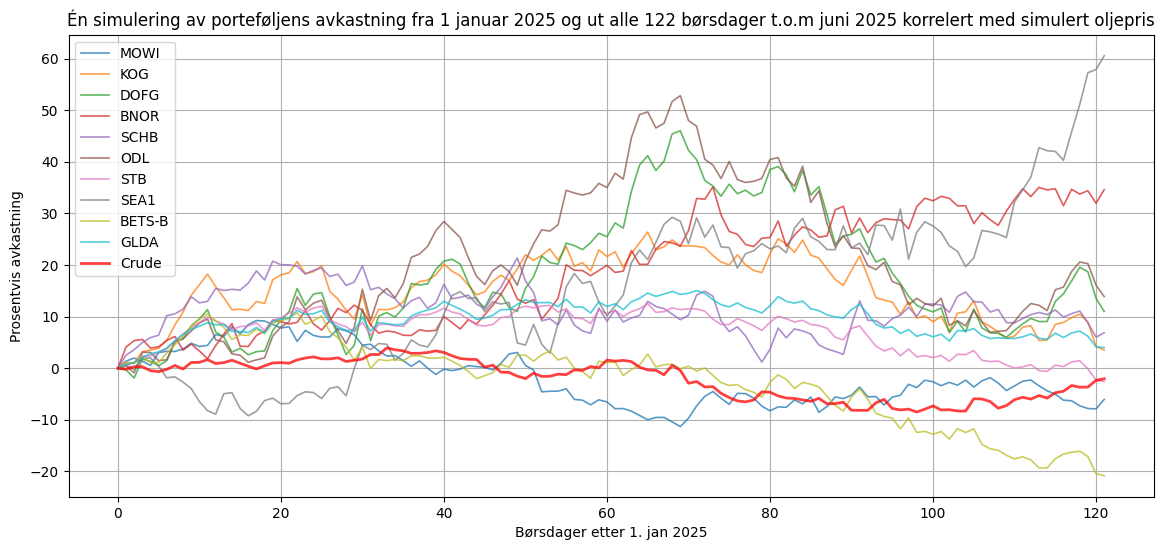

In [399]:
time = range(T)
i = 137
plt.figure(figsize=(14, 6))
for ticker in tickers:
    plt.plot(time, 100*(paths[ticker][i]/paths[ticker][i][0] - 1), label=ticker, lw=1.2, alpha=0.75)

plt.plot(time, 100*(C_t[i] / C_t[0] - 1), label='Crude', lw=2, alpha=0.75, color='red')

plt.legend()
plt.title(f'Én simulering av porteføljens avkastning fra 1 januar 2025 og ut alle 122 børsdager t.o.m juni 2025 korrelert med simulert oljepris')
plt.grid()
plt.xlabel("Børsdager etter 1. jan 2025")
plt.ylabel("Prosentvis avkastning")
plt.show()

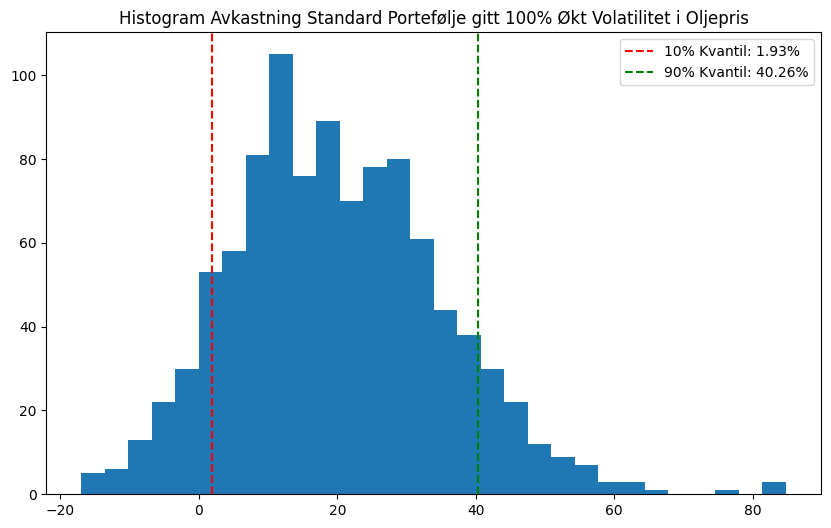

UPI: 1.9119782062809767


In [400]:
avkastninger = {ticker: np.zeros(N) for ticker in tickers}

for ticker in tickers:
    r = 100*(paths[ticker][:, T-1] / paths[ticker][:, 0] - 1)
    avkastninger[ticker] = r

avkastninger_portfolio = []

for i in range(N):
    avkast = 0
    for ticker in tickers:
        avkast += avkastninger[ticker][i] * portfolio[ticker]

    avkastninger_portfolio.append(avkast)

mu_r = np.mean(avkastninger_portfolio)
sd_r = np.sqrt(np.var(avkastninger_portfolio))
_10q = np.sort(avkastninger_portfolio)[int((N-1)*0.1 + 1)]
_90q = np.sort(avkastninger_portfolio)[int((N-1)*0.9 + 1)]

plt.figure(figsize=(10, 6))
plt.hist(avkastninger_portfolio, 30)
plt.title("Histogram Avkastning Standard Portefølje gitt 100% Økt Volatilitet i Oljepris")
plt.axvline(_10q, color="red", linestyle="--", label=f"10% Kvantil: {round(_10q, 2)}%")
plt.axvline(_90q, color="green", linestyle="--", label=f"90% Kvantil: {round(_90q, 2)}%")
plt.legend()

plt.show()
print(f'UPI: {( _90q - abs(_10q))/mu_r}')

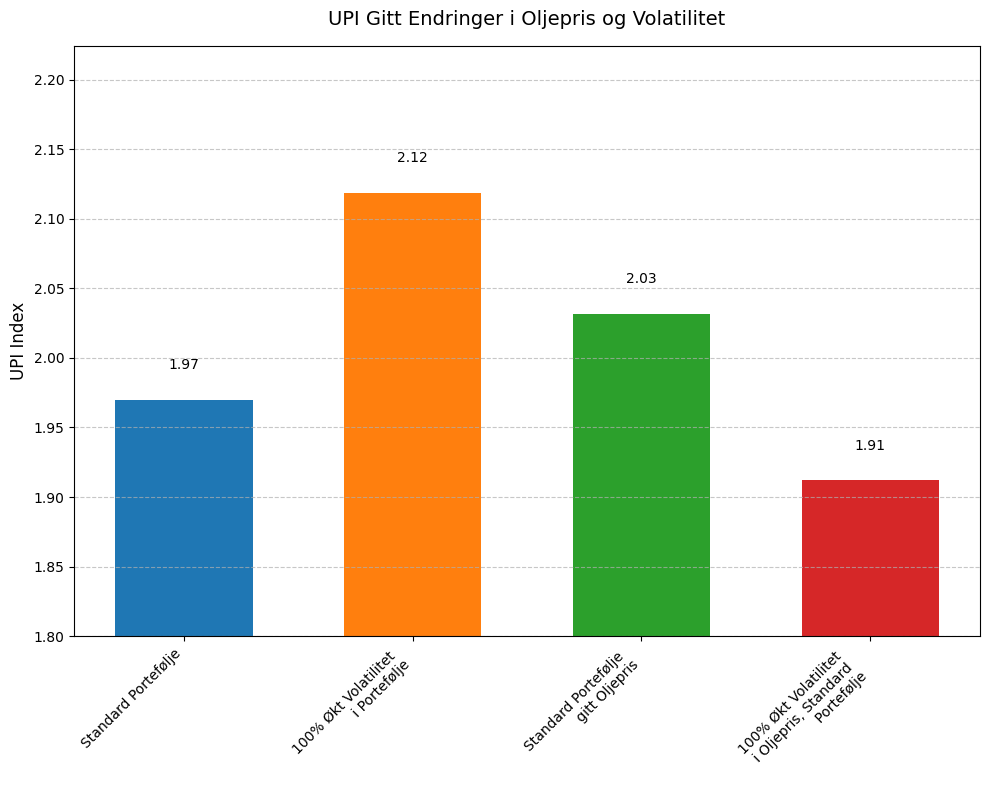

In [401]:
UPI = {
    'Standard Portefølje': 1.9698563453117333,
    '100% Økt Volatilitet \n i Portefølje': 2.118302803353058,
    'Standard Portefølje \n gitt Oljepris': 2.031774413940771,
    '100% Økt Volatilitet \n i Oljepris, Standard \n Portefølje': 1.9119782062809767
}

fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.bar(UPI.keys(), UPI.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], width=0.6)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}',
            ha='center', va='bottom', fontsize=10)

# Format axes and title
ax.set_xticks(range(len(UPI.keys())))
ax.set_xticklabels(UPI.keys(), rotation=45, ha='right', fontsize=10)
ax.set_title("UPI Gitt Endringer i Oljepris og Volatilitet", fontsize=14, pad=15)
ax.set_ylabel("UPI Index", fontsize=12)
ax.set_ylim(bottom=1.8)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.tight_layout()
plt.show()